# Training U-Net for Image Segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
import numpy as np
from collections import Counter
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import random
import os
from glob import glob
from torchvision.transforms import v2
from torchgeo.models import resnet18
from torchgeo.models import ResNet18_Weights
from torchsummary import summary
import utils.train as t
import model.unet as model
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp

In [3]:
# for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading Dataset

In [4]:
image_paths = sorted(glob("data/patches/images/*.npy"))
mask_paths = sorted(glob("data/patches/masks/*.npy"))
dataset = loader.SatelliteDataset(image_paths, mask_paths)
print(len(dataset))

4287


## Data Preprocessing

### Data Exploration
Explore Ground Truth mask 

Tree cover (0): 114844614 pixels
Shrubland (1): 7448541 pixels
Grassland (2): 47982258 pixels
Cropland (3): 64127642 pixels
Built-up (4): 5384116 pixels
Bare/sparse veg. (5): 1242573 pixels
Permanent water bodies (7): 49619945 pixels
Herbaceous wetland (8): 116839 pixels


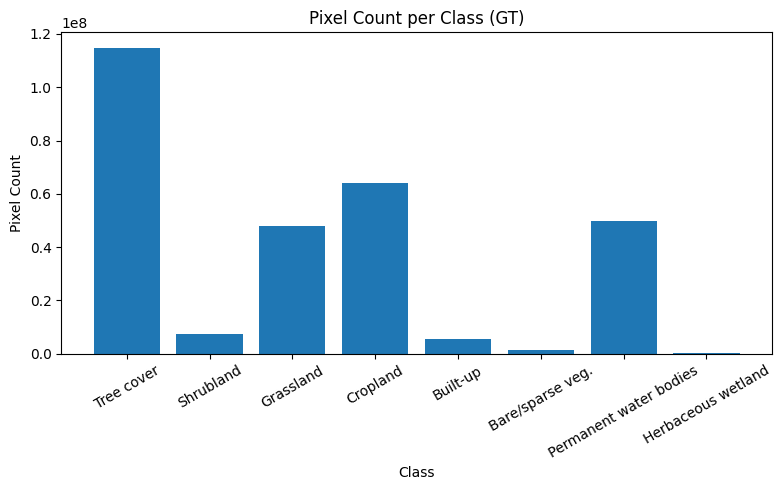

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Permanent water bodies",
    8: "Herbaceous wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}
label_mapping = {
    10: 0,
    20: 1,
    30: 2,
    40: 3,
    50: 4,
    60: 5,
    70: 6,
    80: 7,
    90: 8,
    95: 9,
    100: 10,
}

gt_path = "data/ground_truth/GBDA24_ex2_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)

for raw_val, new_val in label_mapping.items():
    mask[raw_mask == raw_val] = new_val

mask = mask[mask != -1]

unique_classes, counts = np.unique(mask, return_counts=True)
labels = [class_names[c] for c in unique_classes]

for c, count in zip(unique_classes, counts):
    print(f"{class_names[c]} ({c}): {count} pixels")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title("Pixel Count per Class (GT)")
plt.ylabel("Pixel Count")
plt.xlabel("Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Explore dataset's Ground Truth masks

Tree cover (0): 110847191 pixels
Shrubland (1): 7056797 pixels
Grassland (2): 46240261 pixels
Cropland (3): 62773453 pixels
Built-up (4): 5257275 pixels
Bare/sparse veg. (5): 1223690 pixels
Water bodies (6): 47437570 pixels
Wetland (7): 116595 pixels


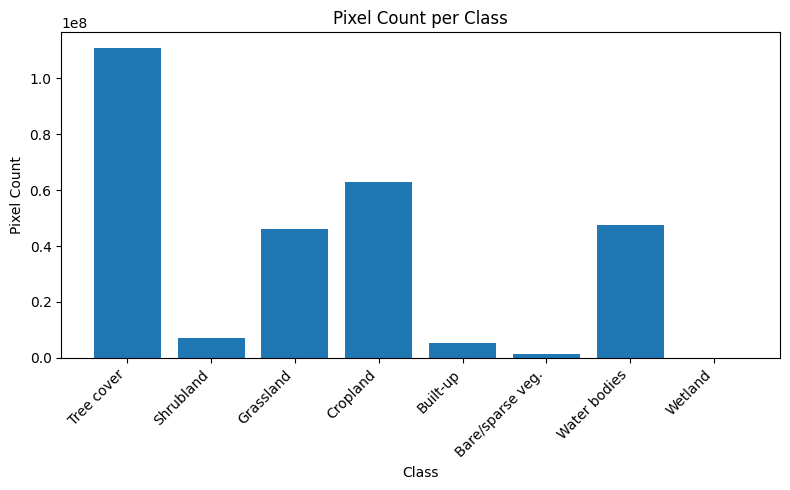

In [14]:
pixel_class_counts = Counter()
for i in range(len(dataset)):
    _, mask = dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Water bodies",
    7: "Wetland",
}

# Create lists for plotting
classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

for cls_id, count in zip(classes, counts):
    label = class_names.get(cls_id, f"Class {cls_id}")
    print(f"{label} ({cls_id}): {count} pixels")

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Clean dataset from NaN values

In [7]:
valid = []
for i in range(len(dataset)):
    image, mask = dataset[i]
    if not (image == -9999).any().item():
        valid.append(i)

print("Initial size of dataset:", len(dataset))
clean_dataset = Subset(dataset, valid)
print("size of cleaned dataset:", len(clean_dataset))

Initial size of dataset: 4287
size of cleaned dataset: 3225


Tree cover (0): 73187522 pixels
Shrubland (1): 5535133 pixels
Grassland (2): 29231702 pixels
Cropland (3): 51641643 pixels
Built-up (4): 4257575 pixels
Bare/sparse veg. (5): 964059 pixels
Snow and ice (6): 46419712 pixels
Water bodies (7): 116254 pixels


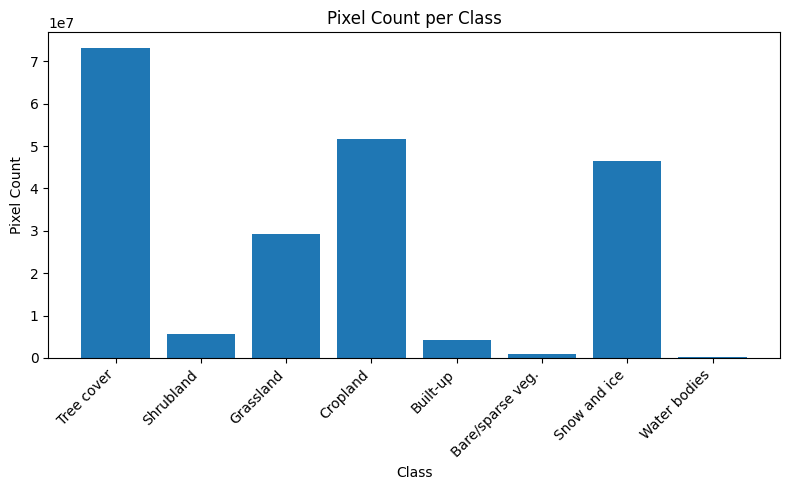

In [13]:
pixel_class_counts = Counter()
for i in range(len(clean_dataset)):
    _, mask = clean_dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

for cls_id, count in zip(classes, counts):
    label = class_names.get(cls_id, f"Class {cls_id}")
    print(f"{label} ({cls_id}): {count} pixels")


# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

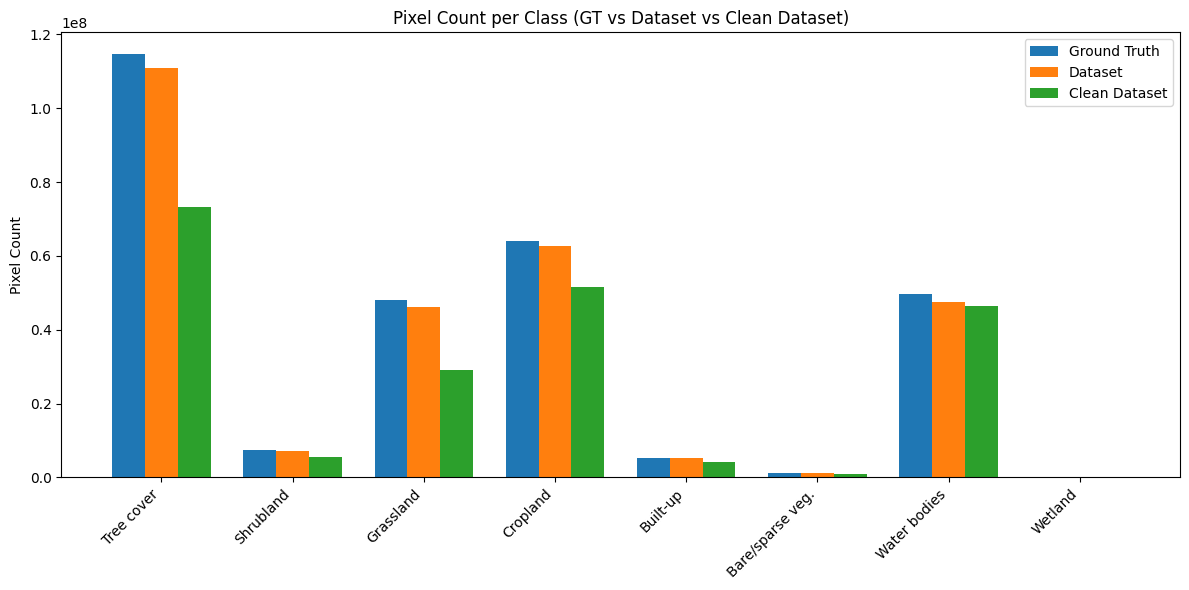

In [ ]:
class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Water bodies",
    7: "Wetland",
}
label_mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
all_class_ids = list(class_names.keys())
gt_path = "data/ground_truth/GBDA24_ex2_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

mapped_mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)
for raw_val, new_val in label_mapping.items():
    mapped_mask[raw_mask == raw_val] = new_val

gt_mask = mapped_mask[mapped_mask != -1]
gt_counts = Counter(gt_mask)
gt_pixel_counts = {c: gt_counts.get(c, 0) for c in all_class_ids}


def count_pixel_classes(dataset):
    counter = Counter()
    for i in range(len(dataset)):
        _, mask = dataset[i]
        if hasattr(mask, "numpy"):
            mask = mask.numpy()
        counter.update(mask.flatten())
    return {c: counter.get(c, 0) for c in all_class_ids}


dataset_counts = count_pixel_classes(dataset)
clean_counts = count_pixel_classes(clean_dataset)

x = np.arange(len(all_class_ids))
bar_width = 0.25

gt_vals = [gt_pixel_counts[c] for c in all_class_ids]
dataset_vals = [dataset_counts[c] for c in all_class_ids]
clean_vals = [clean_counts[c] for c in all_class_ids]

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, gt_vals, width=bar_width, label="Ground Truth")
plt.bar(x, dataset_vals, width=bar_width, label="Dataset")
plt.bar(x + bar_width, clean_vals, width=bar_width, label="Clean Dataset")

plt.xticks(x, [class_names[c] for c in all_class_ids], rotation=45, ha="right")
plt.ylabel("Pixel Count")
plt.title("Pixel Count per Class (GT vs Dataset vs Clean Dataset)")
plt.legend()
plt.tight_layout()
plt.show()

Straify Sampling because of inbalanced dataset

In [30]:
from collections import Counter

# split dataet to 70% training and 30% validation-testing
train_indices, val_indices = train_test_split(
    list(range(len(clean_dataset))),
    test_size=0.3,
    random_state=42,
)

### Normalization and Augmentation

In [31]:
# we apply augmentation only in the training dataset
train_transform = loader.Compose(
    [
        loader.RandomHorizontalFlip(),
        loader.RandomRotation(),
        loader.AddGaussianNoise(0.02),
        loader.Normalize13Band(),
        loader.RandomGaussianBlur(kernel_size=3),
    ],
    with_mask=True,
)

val_transform = loader.Compose([loader.Normalize13Band()], with_mask=True)

In [ ]:
train_dataset = loader.TorchDataset(
    Subset(clean_dataset, train_indices), train_transform
)
val_dataset = loader.TorchDataset(Subset(clean_dataset, val_indices), val_transform)

from collections import Counter
import numpy as np


def compute_pixel_distribution(dataset, indices, num_classes):
    """Compute % of pixels belonging to each class over a subset."""
    pixel_counts = Counter()
    total_pixels = 0

    for i in indices:
        _, mask = dataset[i]
        m = mask.numpy().ravel()
        unique, counts = np.unique(m, return_counts=True)
        for cls, cnt in zip(unique, counts):
            pixel_counts[cls] += int(cnt)
        total_pixels += m.size

    print("Pixel‑level distribution (%):")
    for cls in range(num_classes):
        pct = 100 * pixel_counts.get(cls, 0) / total_pixels
        print(f"  Class {cls:>2}: {pct:5.2f}%")
    return pixel_counts


def compute_patch_presence(dataset, indices, num_classes):
    """Compute % of patches that contain each class at least once."""
    patch_counts = Counter()

    for i in indices:
        _, mask = dataset[i]
        classes_in_patch = np.unique(mask.numpy())
        for cls in classes_in_patch:
            patch_counts[cls] += 1

    total_patches = len(indices)
    print("\nPatch‑level presence (% of patches containing the class):")
    for cls in range(num_classes):
        pct = 100 * patch_counts.get(cls, 0) / total_patches
        print(f"  Class {cls:>2}: {pct:5.2f}%")
    return patch_counts


NUM_CLASSES = 8

print("=== TRAIN SET ===")
train_pixel_counts = compute_pixel_distribution(
    clean_dataset, train_indices, NUM_CLASSES
)
train_patch_counts = compute_patch_presence(clean_dataset, train_indices, NUM_CLASSES)

print("\n=== VALIDATION SET ===")
val_pixel_counts = compute_pixel_distribution(clean_dataset, val_indices, NUM_CLASSES)
val_patch_counts = compute_patch_presence(clean_dataset, val_indices, NUM_CLASSES)

=== TRAIN SET ===
Pixel‑level distribution (%):
  Class  0: 35.02%
  Class  1:  2.65%
  Class  2: 13.67%
  Class  3: 24.19%
  Class  4:  2.04%
  Class  5:  0.42%
  Class  6: 21.96%
  Class  7:  0.05%

Patch‑level presence (% of patches containing the class):
  Class  0: 79.71%
  Class  1: 77.80%
  Class  2: 79.97%
  Class  3: 59.77%
  Class  4: 66.90%
  Class  5: 58.66%
  Class  6: 41.78%
  Class  7:  4.08%

=== VALIDATION SET ===
Pixel‑level distribution (%):
  Class  0: 33.71%
  Class  1:  2.55%
  Class  2: 14.21%
  Class  3: 25.01%
  Class  4:  1.95%
  Class  5:  0.53%
  Class  6: 21.96%
  Class  7:  0.07%

Patch‑level presence (% of patches containing the class):
  Class  0: 80.48%
  Class  1: 77.89%
  Class  2: 80.58%
  Class  3: 60.12%
  Class  4: 67.36%
  Class  5: 61.98%
  Class  6: 43.29%
  Class  7:  5.17%


In [33]:
val_size = int(0.8 * len(val_dataset))
test_size = len(val_dataset) - val_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])
print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

Train size: 2257
Val size:   774
Test size:  194


In [22]:
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

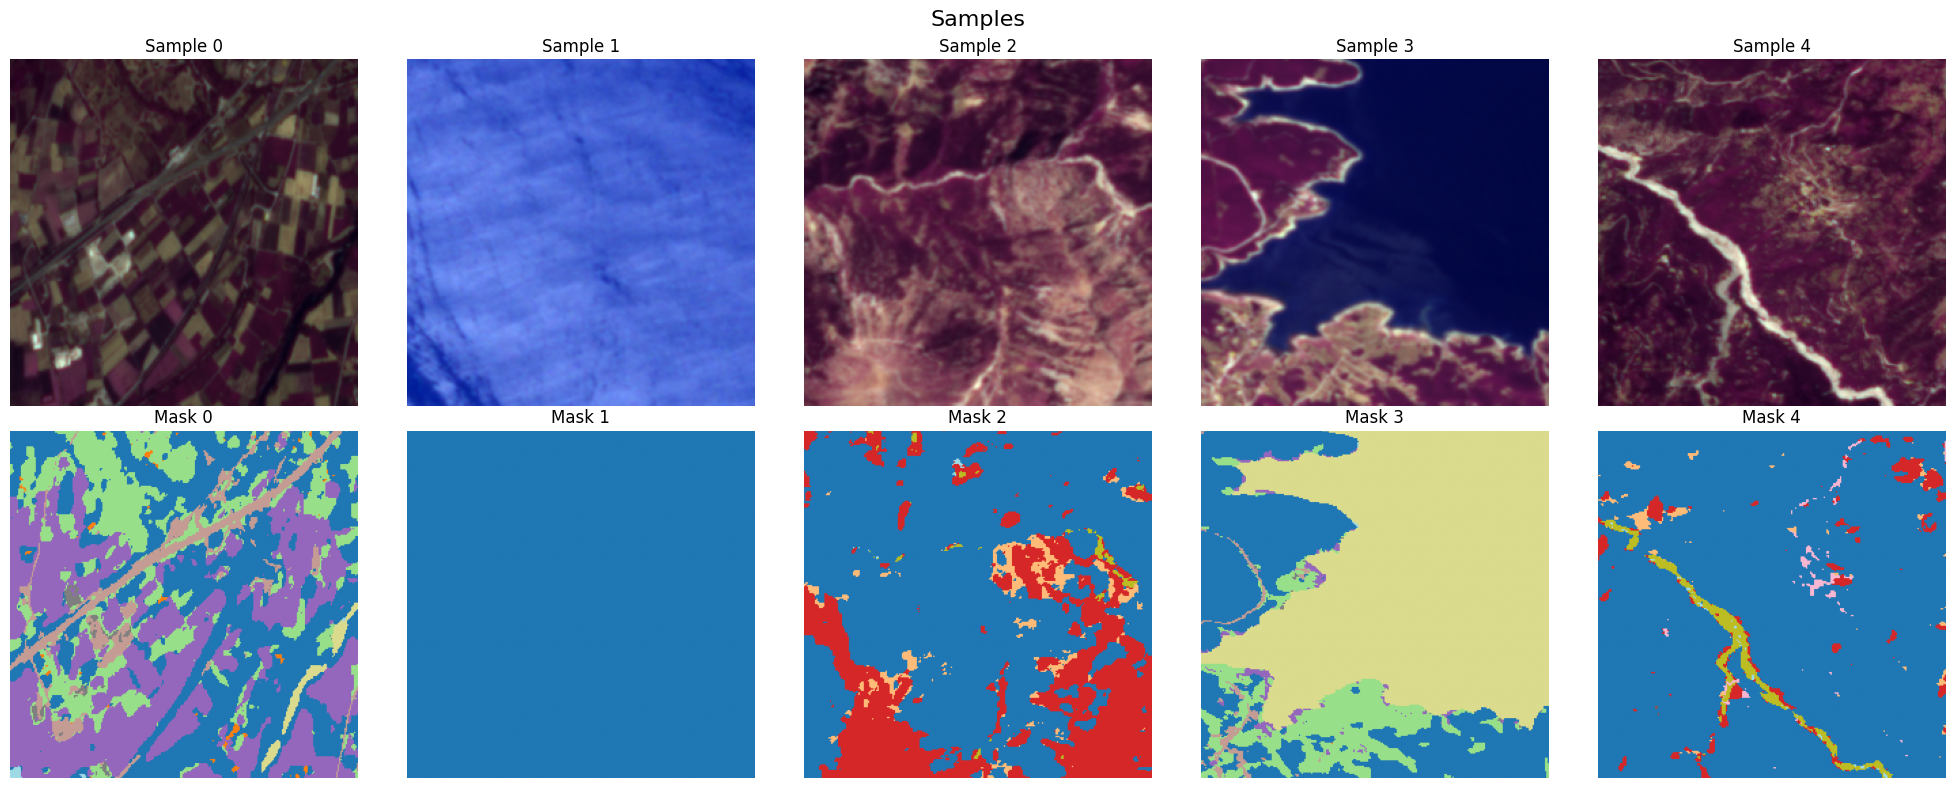

In [23]:
x_batch, y_batch = next(iter(ds_train))  # one batch from training
utils.visualize_samples(
    x_list=[x_batch[i] for i in range(5)],
    y_list=[y_batch[i] for i in range(5)],
    bands=(4, 3, 2),
)

## Model Training

In [12]:
# Architecture of base model

torch.cuda.empty_cache()

resnet = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO, pretrained=True)
resnet.to(device)

summary(resnet, input_size=(13, 256, 256))

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 13 channel(s)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          40,768
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

Due to the dataset's inbalance, weights are going to be used in Loss Function

In [38]:
from collections import Counter

ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

val_labels = []
for _, mask in ds_valid:
    val_labels.extend(mask.flatten().tolist())
print(Counter(val_labels))

train_labels = []
for _, mask in ds_train:
    train_labels.extend(mask.flatten().tolist())
print(Counter(train_labels))

counts = np.array([Counter(train_labels).get(i, 0) for i in range(8)], dtype=np.float32)
weights = 1.0 / (counts + 1e-6)
weights = weights / weights.sum()
class_weights = torch.tensor(weights, dtype=torch.float32).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

Counter({0: 21387628, 3: 15865850, 6: 13933587, 2: 9016250, 1: 1618481, 4: 1239342, 5: 335722, 7: 41988})
Counter({0: 51799894, 3: 35775793, 6: 32486125, 2: 20215452, 1: 3916652, 4: 3018233, 5: 628337, 7: 74266})


#### 1st Experiment: Freezing the encoder and train only the decoder

#### Using Cross Entropy Loss

Epoch 1/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 1/50 | Train Loss: 1.1553 | Train Acc: 0.7814 | Train Dice: 0.7771 || Val Loss: 0.8002 | Val Acc: 0.8411 | Val Dice: 0.8201
New best loss: 0.8002


Epoch 2/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.75it/s]


Epoch 2/50 | Train Loss: 0.6790 | Train Acc: 0.8458 | Train Dice: 0.8269 || Val Loss: 0.5748 | Val Acc: 0.8547 | Val Dice: 0.8395
New best loss: 0.5748


Epoch 3/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.75it/s]


Epoch 3/50 | Train Loss: 0.5285 | Train Acc: 0.8568 | Train Dice: 0.8378 || Val Loss: 0.4545 | Val Acc: 0.8670 | Val Dice: 0.8468
New best loss: 0.4545


Epoch 4/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.73it/s]


Epoch 4/50 | Train Loss: 0.4648 | Train Acc: 0.8650 | Train Dice: 0.8481 || Val Loss: 0.4142 | Val Acc: 0.8735 | Val Dice: 0.8551
New best loss: 0.4142


Epoch 5/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


Epoch 5/50 | Train Loss: 0.4166 | Train Acc: 0.8734 | Train Dice: 0.8573 || Val Loss: 0.3915 | Val Acc: 0.8768 | Val Dice: 0.8600
New best loss: 0.3915


Epoch 6/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.73it/s]


Epoch 6/50 | Train Loss: 0.4030 | Train Acc: 0.8733 | Train Dice: 0.8584 || Val Loss: 0.3642 | Val Acc: 0.8802 | Val Dice: 0.8636
New best loss: 0.3642


Epoch 7/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.73it/s]


Epoch 7/50 | Train Loss: 0.3836 | Train Acc: 0.8761 | Train Dice: 0.8609 || Val Loss: 0.3628 | Val Acc: 0.8777 | Val Dice: 0.8636
New best loss: 0.3628


Epoch 8/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 8/50 | Train Loss: 0.3681 | Train Acc: 0.8789 | Train Dice: 0.8641 || Val Loss: 0.3717 | Val Acc: 0.8721 | Val Dice: 0.8551
 No improvement (1/5)


Epoch 9/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.74it/s]


Epoch 9/50 | Train Loss: 0.3569 | Train Acc: 0.8805 | Train Dice: 0.8661 || Val Loss: 0.3492 | Val Acc: 0.8798 | Val Dice: 0.8641
New best loss: 0.3492


Epoch 10/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.73it/s]


Epoch 10/50 | Train Loss: 0.3493 | Train Acc: 0.8817 | Train Dice: 0.8688 || Val Loss: 0.3375 | Val Acc: 0.8844 | Val Dice: 0.8723
New best loss: 0.3375


Epoch 11/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 11/50 | Train Loss: 0.3387 | Train Acc: 0.8843 | Train Dice: 0.8721 || Val Loss: 0.3355 | Val Acc: 0.8841 | Val Dice: 0.8740
New best loss: 0.3355


Epoch 12/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 12/50 | Train Loss: 0.3314 | Train Acc: 0.8854 | Train Dice: 0.8739 || Val Loss: 0.3286 | Val Acc: 0.8847 | Val Dice: 0.8713
New best loss: 0.3286


Epoch 13/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 13/50 | Train Loss: 0.3296 | Train Acc: 0.8861 | Train Dice: 0.8752 || Val Loss: 0.3286 | Val Acc: 0.8827 | Val Dice: 0.8736
 No improvement (1/5)


Epoch 14/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 14/50 | Train Loss: 0.3249 | Train Acc: 0.8863 | Train Dice: 0.8759 || Val Loss: 0.3182 | Val Acc: 0.8873 | Val Dice: 0.8764
New best loss: 0.3182


Epoch 15/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 15/50 | Train Loss: 0.3176 | Train Acc: 0.8891 | Train Dice: 0.8791 || Val Loss: 0.3191 | Val Acc: 0.8869 | Val Dice: 0.8728
 No improvement (1/5)


Epoch 16/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.67it/s]


Epoch 16/50 | Train Loss: 0.3204 | Train Acc: 0.8875 | Train Dice: 0.8776 || Val Loss: 0.3131 | Val Acc: 0.8879 | Val Dice: 0.8783
New best loss: 0.3131


Epoch 17/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 17/50 | Train Loss: 0.3128 | Train Acc: 0.8899 | Train Dice: 0.8806 || Val Loss: 0.3096 | Val Acc: 0.8884 | Val Dice: 0.8810
New best loss: 0.3096


Epoch 18/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 18/50 | Train Loss: 0.3089 | Train Acc: 0.8903 | Train Dice: 0.8813 || Val Loss: 0.3122 | Val Acc: 0.8869 | Val Dice: 0.8752
 No improvement (1/5)


Epoch 19/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 19/50 | Train Loss: 0.3018 | Train Acc: 0.8926 | Train Dice: 0.8837 || Val Loss: 0.2998 | Val Acc: 0.8913 | Val Dice: 0.8826
New best loss: 0.2998


Epoch 20/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 20/50 | Train Loss: 0.3069 | Train Acc: 0.8907 | Train Dice: 0.8823 || Val Loss: 0.3204 | Val Acc: 0.8836 | Val Dice: 0.8779
 No improvement (1/5)


Epoch 21/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 21/50 | Train Loss: 0.2979 | Train Acc: 0.8936 | Train Dice: 0.8852 || Val Loss: 0.3005 | Val Acc: 0.8910 | Val Dice: 0.8844
 No improvement (2/5)


Epoch 22/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 22/50 | Train Loss: 0.2977 | Train Acc: 0.8942 | Train Dice: 0.8859 || Val Loss: 0.2985 | Val Acc: 0.8916 | Val Dice: 0.8827
New best loss: 0.2985


Epoch 23/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 23/50 | Train Loss: 0.2918 | Train Acc: 0.8955 | Train Dice: 0.8872 || Val Loss: 0.3004 | Val Acc: 0.8906 | Val Dice: 0.8801
 No improvement (1/5)


Epoch 24/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


Epoch 24/50 | Train Loss: 0.2948 | Train Acc: 0.8938 | Train Dice: 0.8857 || Val Loss: 0.2994 | Val Acc: 0.8914 | Val Dice: 0.8851
 No improvement (2/5)


Epoch 25/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 25/50 | Train Loss: 0.2975 | Train Acc: 0.8935 | Train Dice: 0.8856 || Val Loss: 0.3052 | Val Acc: 0.8883 | Val Dice: 0.8821
 No improvement (3/5)


Epoch 26/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


Epoch 26/50 | Train Loss: 0.2970 | Train Acc: 0.8935 | Train Dice: 0.8855 || Val Loss: 0.2951 | Val Acc: 0.8923 | Val Dice: 0.8845
New best loss: 0.2951


Epoch 27/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.66it/s]


Epoch 27/50 | Train Loss: 0.2889 | Train Acc: 0.8955 | Train Dice: 0.8876 || Val Loss: 0.2927 | Val Acc: 0.8929 | Val Dice: 0.8843
New best loss: 0.2927


Epoch 28/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 28/50 | Train Loss: 0.2853 | Train Acc: 0.8966 | Train Dice: 0.8887 || Val Loss: 0.2930 | Val Acc: 0.8926 | Val Dice: 0.8851
 No improvement (1/5)


Epoch 29/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 29/50 | Train Loss: 0.2847 | Train Acc: 0.8968 | Train Dice: 0.8887 || Val Loss: 0.2911 | Val Acc: 0.8930 | Val Dice: 0.8856
New best loss: 0.2911


Epoch 30/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


Epoch 30/50 | Train Loss: 0.2828 | Train Acc: 0.8971 | Train Dice: 0.8892 || Val Loss: 0.2905 | Val Acc: 0.8922 | Val Dice: 0.8864
 No improvement (1/5)


Epoch 31/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 31/50 | Train Loss: 0.2816 | Train Acc: 0.8976 | Train Dice: 0.8899 || Val Loss: 0.2917 | Val Acc: 0.8937 | Val Dice: 0.8843
 No improvement (2/5)


Epoch 32/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 32/50 | Train Loss: 0.2774 | Train Acc: 0.8986 | Train Dice: 0.8909 || Val Loss: 0.2876 | Val Acc: 0.8936 | Val Dice: 0.8871
New best loss: 0.2876


Epoch 33/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 33/50 | Train Loss: 0.2787 | Train Acc: 0.8982 | Train Dice: 0.8904 || Val Loss: 0.2864 | Val Acc: 0.8943 | Val Dice: 0.8882
New best loss: 0.2864


Epoch 34/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 34/50 | Train Loss: 0.2790 | Train Acc: 0.8985 | Train Dice: 0.8909 || Val Loss: 0.2922 | Val Acc: 0.8912 | Val Dice: 0.8864
 No improvement (1/5)


Epoch 35/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 35/50 | Train Loss: 0.2758 | Train Acc: 0.8992 | Train Dice: 0.8915 || Val Loss: 0.2887 | Val Acc: 0.8927 | Val Dice: 0.8871
 No improvement (2/5)


Epoch 36/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.67it/s]


Epoch 36/50 | Train Loss: 0.2762 | Train Acc: 0.8989 | Train Dice: 0.8913 || Val Loss: 0.2899 | Val Acc: 0.8930 | Val Dice: 0.8847
 No improvement (3/5)


Epoch 37/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 37/50 | Train Loss: 0.2744 | Train Acc: 0.8995 | Train Dice: 0.8920 || Val Loss: 0.2848 | Val Acc: 0.8951 | Val Dice: 0.8865
New best loss: 0.2848


Epoch 38/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


Epoch 38/50 | Train Loss: 0.2729 | Train Acc: 0.8999 | Train Dice: 0.8925 || Val Loss: 0.2843 | Val Acc: 0.8943 | Val Dice: 0.8873
 No improvement (1/5)


Epoch 39/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.66it/s]


Epoch 39/50 | Train Loss: 0.2712 | Train Acc: 0.9005 | Train Dice: 0.8931 || Val Loss: 0.2874 | Val Acc: 0.8934 | Val Dice: 0.8868
 No improvement (2/5)


Epoch 40/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 40/50 | Train Loss: 0.2762 | Train Acc: 0.8987 | Train Dice: 0.8910 || Val Loss: 0.2813 | Val Acc: 0.8956 | Val Dice: 0.8884
New best loss: 0.2813


Epoch 41/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


Epoch 41/50 | Train Loss: 0.2710 | Train Acc: 0.9005 | Train Dice: 0.8933 || Val Loss: 0.2821 | Val Acc: 0.8955 | Val Dice: 0.8887
 No improvement (1/5)


Epoch 42/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 42/50 | Train Loss: 0.2688 | Train Acc: 0.9012 | Train Dice: 0.8938 || Val Loss: 0.2813 | Val Acc: 0.8953 | Val Dice: 0.8882
 No improvement (2/5)


Epoch 43/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 43/50 | Train Loss: 0.2723 | Train Acc: 0.8999 | Train Dice: 0.8924 || Val Loss: 0.2798 | Val Acc: 0.8961 | Val Dice: 0.8879
New best loss: 0.2798


Epoch 44/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 44/50 | Train Loss: 0.2693 | Train Acc: 0.9009 | Train Dice: 0.8937 || Val Loss: 0.2822 | Val Acc: 0.8951 | Val Dice: 0.8867
 No improvement (1/5)


Epoch 45/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 45/50 | Train Loss: 0.2657 | Train Acc: 0.9019 | Train Dice: 0.8945 || Val Loss: 0.2801 | Val Acc: 0.8957 | Val Dice: 0.8889
 No improvement (2/5)


Epoch 46/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


Epoch 46/50 | Train Loss: 0.2713 | Train Acc: 0.9005 | Train Dice: 0.8935 || Val Loss: 0.2868 | Val Acc: 0.8933 | Val Dice: 0.8884
 No improvement (3/5)


Epoch 47/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


Epoch 47/50 | Train Loss: 0.2661 | Train Acc: 0.9018 | Train Dice: 0.8945 || Val Loss: 0.2851 | Val Acc: 0.8934 | Val Dice: 0.8860
 No improvement (4/5)


Epoch 48/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


Epoch 48/50 | Train Loss: 0.2667 | Train Acc: 0.9016 | Train Dice: 0.8944 || Val Loss: 0.2811 | Val Acc: 0.8949 | Val Dice: 0.8891
 No improvement (5/5)
Early stopping triggered.


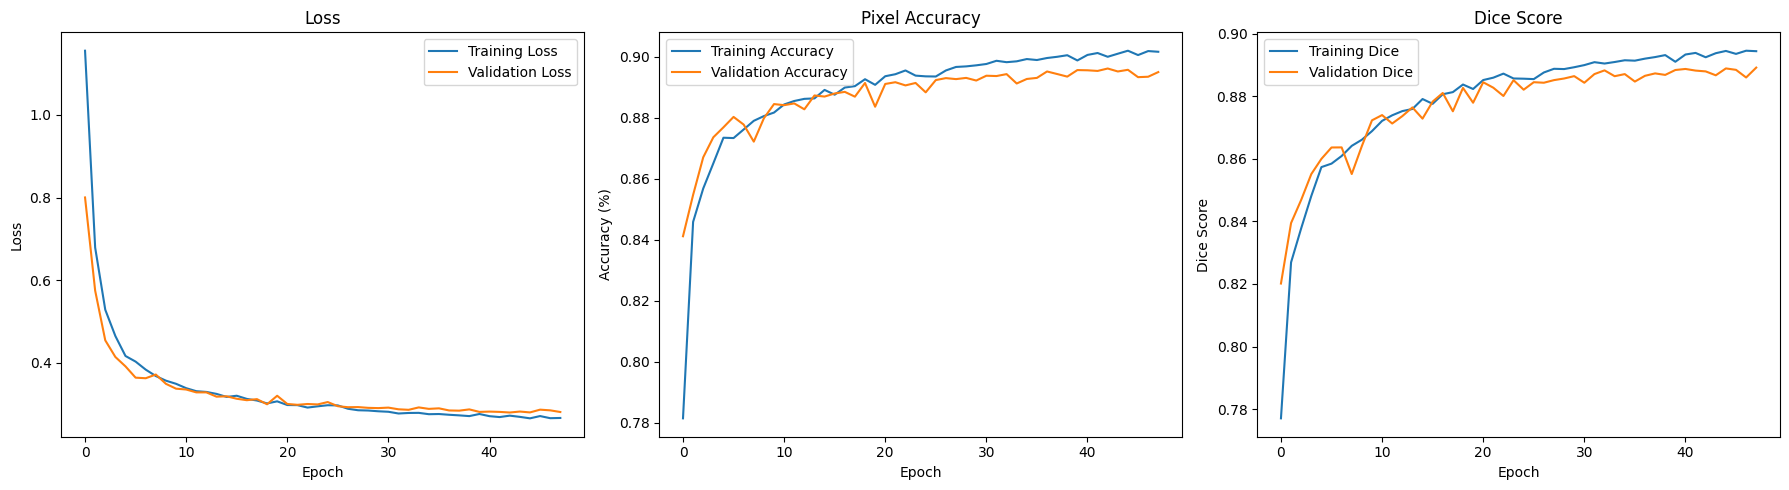

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


 Evaluation Results:
Loss: 0.2926 | Pixel Accuracy: 89.01% | Dice Score: 0.8840 | Mean IoUScore: 0.1654


In [ ]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

# Train only the decoder of Unet
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)

criterion = nn.CrossEntropyLoss()

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/exp_01_1_unfreezed_retrained.pt",
    )
)

# Evaluate
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)

In [ ]:
t.segmentation_report(unet, ds_valid)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9144    0.9227    0.9185  21387628
     Class 1     0.5380    0.3243    0.4047   1618481
     Class 2     0.7399    0.7833    0.7610   9016250
     Class 3     0.9083    0.9174    0.9128  15865850
     Class 4     0.7133    0.6291    0.6686   1239342
     Class 5     0.7350    0.6777    0.7051    335722
     Class 6     0.9985    0.9968    0.9977  13933587
     Class 7     0.0000    0.0000    0.0000     41988

    accuracy                         0.8949  63438848
   macro avg     0.6934    0.6564    0.6711  63438848
weighted avg     0.8915    0.8949    0.8924  63438848

=== Dice per Class ===
Class 0: 0.9185
Class 1: 0.4047
Class 2: 0.7610
Class 3: 0.9128
Class 4: 0.6686
Class 5: 0.7051
Class 6: 0.9977
Class 7: 0.0000


#### Using Dice Loss

Epoch 1/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  6.19it/s]


Epoch 1/50 | Train Loss: 0.7528 | Train Acc: 0.6860 | Train Dice: 0.7101 || Val Loss: 0.6839 | Val Acc: 0.8214 | Val Dice: 0.8157
New best loss: 0.6839


Epoch 2/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 2/50 | Train Loss: 0.5907 | Train Acc: 0.8383 | Train Dice: 0.8309 || Val Loss: 0.5527 | Val Acc: 0.8550 | Val Dice: 0.8462
New best loss: 0.5527


Epoch 3/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 3/50 | Train Loss: 0.5044 | Train Acc: 0.8566 | Train Dice: 0.8477 || Val Loss: 0.4806 | Val Acc: 0.8608 | Val Dice: 0.8562
New best loss: 0.4806


Epoch 4/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 4/50 | Train Loss: 0.4479 | Train Acc: 0.8578 | Train Dice: 0.8528 || Val Loss: 0.4197 | Val Acc: 0.8680 | Val Dice: 0.8612
New best loss: 0.4197


Epoch 5/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 5/50 | Train Loss: 0.3969 | Train Acc: 0.8638 | Train Dice: 0.8589 || Val Loss: 0.4169 | Val Acc: 0.8639 | Val Dice: 0.8563
New best loss: 0.4169


Epoch 6/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 6/50 | Train Loss: 0.3764 | Train Acc: 0.8672 | Train Dice: 0.8628 || Val Loss: 0.3805 | Val Acc: 0.8670 | Val Dice: 0.8629
New best loss: 0.3805


Epoch 7/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 7/50 | Train Loss: 0.3669 | Train Acc: 0.8721 | Train Dice: 0.8671 || Val Loss: 0.3707 | Val Acc: 0.8750 | Val Dice: 0.8698
New best loss: 0.3707


Epoch 8/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 8/50 | Train Loss: 0.3488 | Train Acc: 0.8729 | Train Dice: 0.8681 || Val Loss: 0.3575 | Val Acc: 0.8743 | Val Dice: 0.8703
New best loss: 0.3575


Epoch 9/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 9/50 | Train Loss: 0.3495 | Train Acc: 0.8737 | Train Dice: 0.8692 || Val Loss: 0.3594 | Val Acc: 0.8731 | Val Dice: 0.8702
 No improvement (1/5)


Epoch 10/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 10/50 | Train Loss: 0.3539 | Train Acc: 0.8744 | Train Dice: 0.8698 || Val Loss: 0.3564 | Val Acc: 0.8791 | Val Dice: 0.8730
New best loss: 0.3564


Epoch 11/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 11/50 | Train Loss: 0.3487 | Train Acc: 0.8767 | Train Dice: 0.8722 || Val Loss: 0.3516 | Val Acc: 0.8782 | Val Dice: 0.8740
New best loss: 0.3516


Epoch 12/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 12/50 | Train Loss: 0.3378 | Train Acc: 0.8791 | Train Dice: 0.8745 || Val Loss: 0.3487 | Val Acc: 0.8796 | Val Dice: 0.8711
New best loss: 0.3487


Epoch 13/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 13/50 | Train Loss: 0.3406 | Train Acc: 0.8799 | Train Dice: 0.8753 || Val Loss: 0.3449 | Val Acc: 0.8822 | Val Dice: 0.8748
New best loss: 0.3449


Epoch 14/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 14/50 | Train Loss: 0.3394 | Train Acc: 0.8811 | Train Dice: 0.8763 || Val Loss: 0.3515 | Val Acc: 0.8777 | Val Dice: 0.8724
 No improvement (1/5)


Epoch 15/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 15/50 | Train Loss: 0.3234 | Train Acc: 0.8809 | Train Dice: 0.8761 || Val Loss: 0.3505 | Val Acc: 0.8785 | Val Dice: 0.8725
 No improvement (2/5)


Epoch 16/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 16/50 | Train Loss: 0.3226 | Train Acc: 0.8804 | Train Dice: 0.8763 || Val Loss: 0.3310 | Val Acc: 0.8802 | Val Dice: 0.8726
New best loss: 0.3310


Epoch 17/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 17/50 | Train Loss: 0.3167 | Train Acc: 0.8828 | Train Dice: 0.8780 || Val Loss: 0.3288 | Val Acc: 0.8847 | Val Dice: 0.8790
New best loss: 0.3288


Epoch 18/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.29it/s]


Epoch 18/50 | Train Loss: 0.3292 | Train Acc: 0.8825 | Train Dice: 0.8781 || Val Loss: 0.3305 | Val Acc: 0.8804 | Val Dice: 0.8767
 No improvement (1/5)


Epoch 19/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 19/50 | Train Loss: 0.3254 | Train Acc: 0.8826 | Train Dice: 0.8780 || Val Loss: 0.3306 | Val Acc: 0.8782 | Val Dice: 0.8749
 No improvement (2/5)


Epoch 20/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 20/50 | Train Loss: 0.3216 | Train Acc: 0.8834 | Train Dice: 0.8794 || Val Loss: 0.3362 | Val Acc: 0.8734 | Val Dice: 0.8735
 No improvement (3/5)


Epoch 21/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 21/50 | Train Loss: 0.3099 | Train Acc: 0.8843 | Train Dice: 0.8797 || Val Loss: 0.3373 | Val Acc: 0.8784 | Val Dice: 0.8741
 No improvement (4/5)


Epoch 22/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 22/50 | Train Loss: 0.3108 | Train Acc: 0.8829 | Train Dice: 0.8786 || Val Loss: 0.3127 | Val Acc: 0.8851 | Val Dice: 0.8791
New best loss: 0.3127


Epoch 23/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 23/50 | Train Loss: 0.3140 | Train Acc: 0.8845 | Train Dice: 0.8801 || Val Loss: 0.3352 | Val Acc: 0.8787 | Val Dice: 0.8725
 No improvement (1/5)


Epoch 24/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 24/50 | Train Loss: 0.3033 | Train Acc: 0.8854 | Train Dice: 0.8807 || Val Loss: 0.3217 | Val Acc: 0.8848 | Val Dice: 0.8790
 No improvement (2/5)


Epoch 25/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 25/50 | Train Loss: 0.3138 | Train Acc: 0.8858 | Train Dice: 0.8812 || Val Loss: 0.3186 | Val Acc: 0.8808 | Val Dice: 0.8774
 No improvement (3/5)


Epoch 26/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 26/50 | Train Loss: 0.3039 | Train Acc: 0.8861 | Train Dice: 0.8818 || Val Loss: 0.3189 | Val Acc: 0.8827 | Val Dice: 0.8789
 No improvement (4/5)


Epoch 27/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 27/50 | Train Loss: 0.3019 | Train Acc: 0.8860 | Train Dice: 0.8815 || Val Loss: 0.3125 | Val Acc: 0.8816 | Val Dice: 0.8784
 No improvement (5/5)
Early stopping triggered.


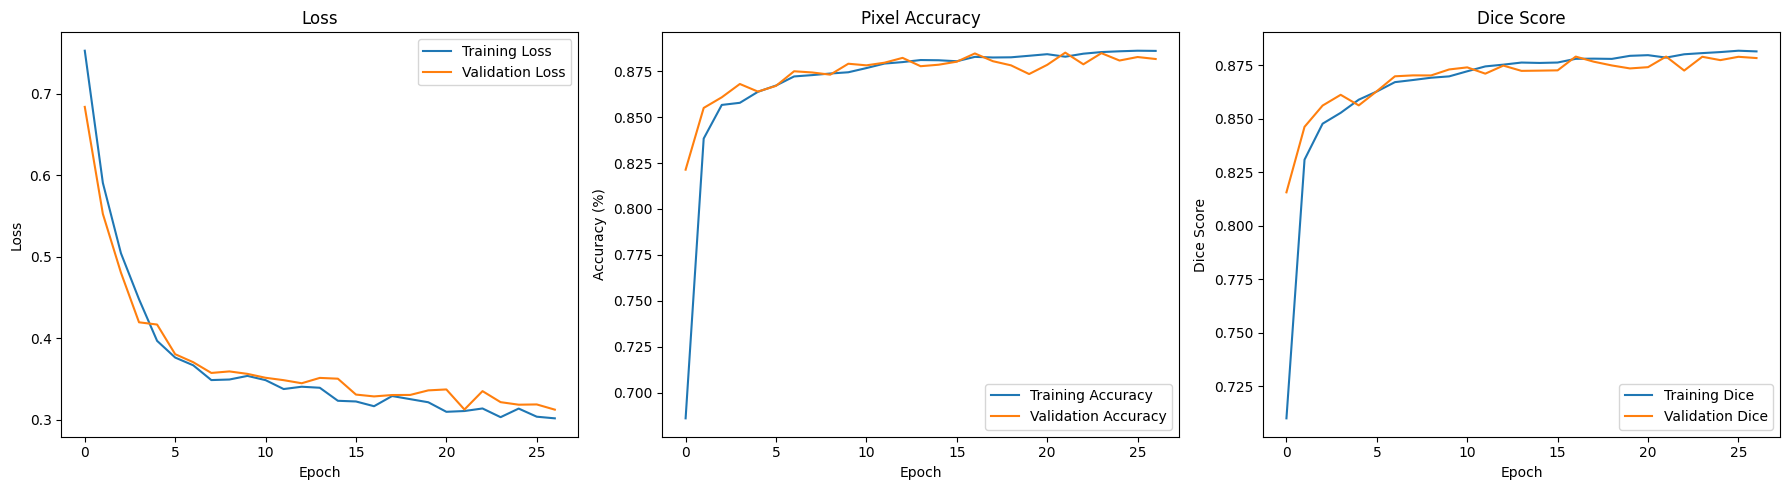

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]



 Evaluation Results:
Loss: 0.3452 | Pixel Accuracy: 87.55% | Dice Score: 0.8724 | Mean IoUScore: 0.0503
=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9131    0.9009    0.9069  21387628
     Class 1     0.3828    0.4896    0.4296   1618481
     Class 2     0.7449    0.7106    0.7273   9016250
     Class 3     0.8958    0.9141    0.9048  15865850
     Class 4     0.6811    0.6709    0.6759   1239342
     Class 5     0.7295    0.7148    0.7221    335722
     Class 6     0.9979    0.9960    0.9970  13933587
     Class 7     0.5948    0.2698    0.3712     41988

    accuracy                         0.8816  63438848
   macro avg     0.7425    0.7083    0.7169  63438848
weighted avg     0.8842    0.8816    0.8826  63438848

=== Dice per Class ===
Class 0: 0.9069
Class 1: 0.4296
Class 2: 0.7273
Class 3: 0.9048
Class 4: 0.6759
Class 5: 0.7221
Class 6: 0.9970
Class 7: 0.3712


In [ ]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

# Train only the decoder of Unet
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)

criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/exp_01_1_dice_loss.pt",
    )
)

# Evaluate
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)
t.segmentation_report(unet, ds_valid)

#### Using Dice + CrossEntropy Loss (Hybrid Approach)

In [47]:
class HybridLoss(nn.Module):
    def __init__(self, ce_weight, a):
        super(HybridLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
        self.a = a

    def forward(self, logits, targets):
        return self.ce(logits, targets) + self.a * self.dice(logits, targets)

Epoch 1/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


Epoch 1/50 | Train Loss: 1.6393 | Train Acc: 0.7191 | Train Dice: 0.7279 || Val Loss: 1.2380 | Val Acc: 0.8312 | Val Dice: 0.8147
New best loss: 1.2380


Epoch 2/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 2/50 | Train Loss: 1.0370 | Train Acc: 0.8418 | Train Dice: 0.8228 || Val Loss: 0.9219 | Val Acc: 0.8544 | Val Dice: 0.8372
New best loss: 0.9219


Epoch 3/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 3/50 | Train Loss: 0.8530 | Train Acc: 0.8553 | Train Dice: 0.8359 || Val Loss: 0.7874 | Val Acc: 0.8631 | Val Dice: 0.8427
New best loss: 0.7874


Epoch 4/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 4/50 | Train Loss: 0.7568 | Train Acc: 0.8628 | Train Dice: 0.8437 || Val Loss: 0.7353 | Val Acc: 0.8677 | Val Dice: 0.8531
New best loss: 0.7353


Epoch 5/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  6.19it/s]


Epoch 5/50 | Train Loss: 0.7010 | Train Acc: 0.8723 | Train Dice: 0.8566 || Val Loss: 0.6629 | Val Acc: 0.8762 | Val Dice: 0.8606
New best loss: 0.6629


Epoch 6/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 6/50 | Train Loss: 0.6601 | Train Acc: 0.8755 | Train Dice: 0.8607 || Val Loss: 0.6331 | Val Acc: 0.8778 | Val Dice: 0.8597
New best loss: 0.6331


Epoch 7/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 7/50 | Train Loss: 0.6301 | Train Acc: 0.8783 | Train Dice: 0.8636 || Val Loss: 0.6086 | Val Acc: 0.8804 | Val Dice: 0.8644
New best loss: 0.6086


Epoch 8/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 8/50 | Train Loss: 0.6182 | Train Acc: 0.8778 | Train Dice: 0.8640 || Val Loss: 0.5857 | Val Acc: 0.8818 | Val Dice: 0.8692
New best loss: 0.5857


Epoch 9/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 9/50 | Train Loss: 0.5932 | Train Acc: 0.8814 | Train Dice: 0.8700 || Val Loss: 0.5889 | Val Acc: 0.8803 | Val Dice: 0.8705
 No improvement (1/5)


Epoch 10/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 10/50 | Train Loss: 0.5697 | Train Acc: 0.8850 | Train Dice: 0.8756 || Val Loss: 0.5565 | Val Acc: 0.8865 | Val Dice: 0.8781
New best loss: 0.5565


Epoch 11/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 11/50 | Train Loss: 0.5579 | Train Acc: 0.8863 | Train Dice: 0.8780 || Val Loss: 0.5427 | Val Acc: 0.8877 | Val Dice: 0.8783
New best loss: 0.5427


Epoch 12/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 12/50 | Train Loss: 0.5438 | Train Acc: 0.8875 | Train Dice: 0.8797 || Val Loss: 0.5418 | Val Acc: 0.8865 | Val Dice: 0.8792
 No improvement (1/5)


Epoch 13/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.21it/s]


Epoch 13/50 | Train Loss: 0.5351 | Train Acc: 0.8862 | Train Dice: 0.8792 || Val Loss: 0.5288 | Val Acc: 0.8883 | Val Dice: 0.8784
New best loss: 0.5288


Epoch 14/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 14/50 | Train Loss: 0.5315 | Train Acc: 0.8865 | Train Dice: 0.8792 || Val Loss: 0.5154 | Val Acc: 0.8905 | Val Dice: 0.8815
New best loss: 0.5154


Epoch 15/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 15/50 | Train Loss: 0.5110 | Train Acc: 0.8906 | Train Dice: 0.8832 || Val Loss: 0.5050 | Val Acc: 0.8894 | Val Dice: 0.8814
New best loss: 0.5050


Epoch 16/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 16/50 | Train Loss: 0.5085 | Train Acc: 0.8900 | Train Dice: 0.8831 || Val Loss: 0.5086 | Val Acc: 0.8901 | Val Dice: 0.8829
 No improvement (1/5)


Epoch 17/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 17/50 | Train Loss: 0.5070 | Train Acc: 0.8896 | Train Dice: 0.8828 || Val Loss: 0.5064 | Val Acc: 0.8892 | Val Dice: 0.8823
 No improvement (2/5)


Epoch 18/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 18/50 | Train Loss: 0.5049 | Train Acc: 0.8908 | Train Dice: 0.8837 || Val Loss: 0.5189 | Val Acc: 0.8865 | Val Dice: 0.8811
 No improvement (3/5)


Epoch 19/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 19/50 | Train Loss: 0.4979 | Train Acc: 0.8915 | Train Dice: 0.8847 || Val Loss: 0.5148 | Val Acc: 0.8857 | Val Dice: 0.8819
 No improvement (4/5)


Epoch 20/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 20/50 | Train Loss: 0.4961 | Train Acc: 0.8923 | Train Dice: 0.8855 || Val Loss: 0.4993 | Val Acc: 0.8921 | Val Dice: 0.8828
New best loss: 0.4993


Epoch 21/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 21/50 | Train Loss: 0.4922 | Train Acc: 0.8923 | Train Dice: 0.8855 || Val Loss: 0.4963 | Val Acc: 0.8927 | Val Dice: 0.8846
New best loss: 0.4963


Epoch 22/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 22/50 | Train Loss: 0.4842 | Train Acc: 0.8935 | Train Dice: 0.8870 || Val Loss: 0.4908 | Val Acc: 0.8931 | Val Dice: 0.8853
New best loss: 0.4908


Epoch 23/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.29it/s]


Epoch 23/50 | Train Loss: 0.4784 | Train Acc: 0.8943 | Train Dice: 0.8877 || Val Loss: 0.4921 | Val Acc: 0.8908 | Val Dice: 0.8857
 No improvement (1/5)


Epoch 24/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 24/50 | Train Loss: 0.4784 | Train Acc: 0.8946 | Train Dice: 0.8879 || Val Loss: 0.4978 | Val Acc: 0.8919 | Val Dice: 0.8825
 No improvement (2/5)


Epoch 25/50 [Val]: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Epoch 25/50 | Train Loss: 0.4777 | Train Acc: 0.8953 | Train Dice: 0.8889 || Val Loss: 0.4869 | Val Acc: 0.8911 | Val Dice: 0.8845
New best loss: 0.4869


Epoch 26/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 26/50 | Train Loss: 0.4738 | Train Acc: 0.8959 | Train Dice: 0.8893 || Val Loss: 0.4793 | Val Acc: 0.8943 | Val Dice: 0.8877
New best loss: 0.4793


Epoch 27/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 27/50 | Train Loss: 0.4765 | Train Acc: 0.8959 | Train Dice: 0.8893 || Val Loss: 0.4795 | Val Acc: 0.8939 | Val Dice: 0.8873
 No improvement (1/5)


Epoch 28/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 28/50 | Train Loss: 0.4626 | Train Acc: 0.8968 | Train Dice: 0.8905 || Val Loss: 0.4832 | Val Acc: 0.8908 | Val Dice: 0.8832
 No improvement (2/5)


Epoch 29/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 29/50 | Train Loss: 0.4657 | Train Acc: 0.8965 | Train Dice: 0.8901 || Val Loss: 0.4773 | Val Acc: 0.8935 | Val Dice: 0.8862
New best loss: 0.4773


Epoch 30/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 30/50 | Train Loss: 0.4670 | Train Acc: 0.8969 | Train Dice: 0.8904 || Val Loss: 0.4899 | Val Acc: 0.8911 | Val Dice: 0.8845
 No improvement (1/5)


Epoch 31/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 31/50 | Train Loss: 0.4684 | Train Acc: 0.8973 | Train Dice: 0.8911 || Val Loss: 0.5098 | Val Acc: 0.8838 | Val Dice: 0.8790
 No improvement (2/5)


Epoch 32/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 32/50 | Train Loss: 0.4642 | Train Acc: 0.8973 | Train Dice: 0.8912 || Val Loss: 0.4789 | Val Acc: 0.8942 | Val Dice: 0.8877
 No improvement (3/5)


Epoch 33/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 33/50 | Train Loss: 0.4586 | Train Acc: 0.8979 | Train Dice: 0.8915 || Val Loss: 0.4765 | Val Acc: 0.8930 | Val Dice: 0.8871
 No improvement (4/5)


Epoch 34/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 34/50 | Train Loss: 0.4658 | Train Acc: 0.8979 | Train Dice: 0.8916 || Val Loss: 0.4703 | Val Acc: 0.8946 | Val Dice: 0.8874
New best loss: 0.4703


Epoch 35/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 35/50 | Train Loss: 0.4531 | Train Acc: 0.8987 | Train Dice: 0.8925 || Val Loss: 0.4799 | Val Acc: 0.8913 | Val Dice: 0.8855
 No improvement (1/5)


Epoch 36/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


Epoch 36/50 | Train Loss: 0.4575 | Train Acc: 0.8983 | Train Dice: 0.8920 || Val Loss: 0.4754 | Val Acc: 0.8932 | Val Dice: 0.8869
 No improvement (2/5)


Epoch 37/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 37/50 | Train Loss: 0.4532 | Train Acc: 0.8997 | Train Dice: 0.8936 || Val Loss: 0.4718 | Val Acc: 0.8957 | Val Dice: 0.8885
 No improvement (3/5)


Epoch 38/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 38/50 | Train Loss: 0.4520 | Train Acc: 0.9001 | Train Dice: 0.8939 || Val Loss: 0.4866 | Val Acc: 0.8911 | Val Dice: 0.8850
 No improvement (4/5)


Epoch 39/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 39/50 | Train Loss: 0.4539 | Train Acc: 0.9001 | Train Dice: 0.8939 || Val Loss: 0.4677 | Val Acc: 0.8953 | Val Dice: 0.8889
New best loss: 0.4677


Epoch 40/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 40/50 | Train Loss: 0.4583 | Train Acc: 0.8991 | Train Dice: 0.8929 || Val Loss: 0.4773 | Val Acc: 0.8918 | Val Dice: 0.8857
 No improvement (1/5)


Epoch 41/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 41/50 | Train Loss: 0.4560 | Train Acc: 0.9002 | Train Dice: 0.8941 || Val Loss: 0.4719 | Val Acc: 0.8952 | Val Dice: 0.8879
 No improvement (2/5)


Epoch 42/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 42/50 | Train Loss: 0.4544 | Train Acc: 0.9007 | Train Dice: 0.8947 || Val Loss: 0.4656 | Val Acc: 0.8961 | Val Dice: 0.8894
New best loss: 0.4656


Epoch 43/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 43/50 | Train Loss: 0.4511 | Train Acc: 0.9002 | Train Dice: 0.8943 || Val Loss: 0.4697 | Val Acc: 0.8963 | Val Dice: 0.8886
 No improvement (1/5)


Epoch 44/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.22it/s]


Epoch 44/50 | Train Loss: 0.4473 | Train Acc: 0.9003 | Train Dice: 0.8943 || Val Loss: 0.4618 | Val Acc: 0.8950 | Val Dice: 0.8898
New best loss: 0.4618


Epoch 45/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 45/50 | Train Loss: 0.4503 | Train Acc: 0.8999 | Train Dice: 0.8938 || Val Loss: 0.4747 | Val Acc: 0.8941 | Val Dice: 0.8868
 No improvement (1/5)


Epoch 46/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


Epoch 46/50 | Train Loss: 0.4437 | Train Acc: 0.9004 | Train Dice: 0.8940 || Val Loss: 0.4686 | Val Acc: 0.8943 | Val Dice: 0.8887
 No improvement (2/5)


Epoch 47/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.22it/s]


Epoch 47/50 | Train Loss: 0.4389 | Train Acc: 0.9014 | Train Dice: 0.8956 || Val Loss: 0.4645 | Val Acc: 0.8963 | Val Dice: 0.8879
 No improvement (3/5)


Epoch 48/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 48/50 | Train Loss: 0.4355 | Train Acc: 0.9024 | Train Dice: 0.8963 || Val Loss: 0.4636 | Val Acc: 0.8968 | Val Dice: 0.8892
 No improvement (4/5)


Epoch 49/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Epoch 49/50 | Train Loss: 0.4361 | Train Acc: 0.9027 | Train Dice: 0.8969 || Val Loss: 0.4571 | Val Acc: 0.8958 | Val Dice: 0.8897
New best loss: 0.4571


Epoch 50/50 [Val]: 100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


Epoch 50/50 | Train Loss: 0.4408 | Train Acc: 0.9002 | Train Dice: 0.8942 || Val Loss: 0.4602 | Val Acc: 0.8960 | Val Dice: 0.8903
 No improvement (1/5)


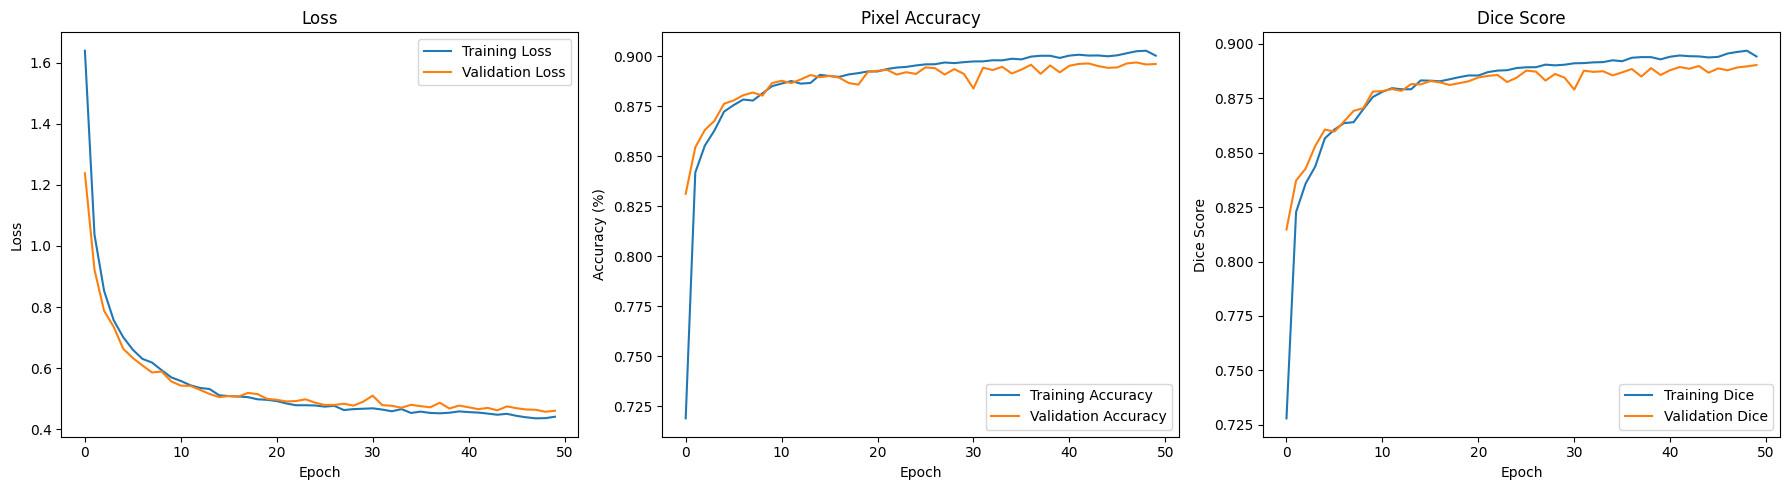

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]



 Evaluation Results:
Loss: 0.4752 | Pixel Accuracy: 89.07% | Dice Score: 0.8850 | Mean IoUScore: 0.1953
=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9102    0.9246    0.9173  21387628
     Class 1     0.5783    0.2764    0.3740   1618481
     Class 2     0.7529    0.7706    0.7616   9016250
     Class 3     0.9111    0.9219    0.9165  15865850
     Class 4     0.6672    0.6981    0.6823   1239342
     Class 5     0.6734    0.7833    0.7242    335722
     Class 6     0.9982    0.9972    0.9977  13933587
     Class 7     0.4932    0.5941    0.5390     41988

    accuracy                         0.8960  63438848
   macro avg     0.7481    0.7458    0.7391  63438848
weighted avg     0.8926    0.8960    0.8929  63438848

=== Dice per Class ===
Class 0: 0.9173
Class 1: 0.3740
Class 2: 0.7616
Class 3: 0.9165
Class 4: 0.6823
Class 5: 0.7242
Class 6: 0.9977
Class 7: 0.5390


In [48]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

# Train only the decoder of Unet
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)

criterion = HybridLoss(class_weights, a=0.5)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/exp_01_1_hybrid_loss.pt",
    )
)

# Evaluate
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)
t.segmentation_report(unet, ds_valid)

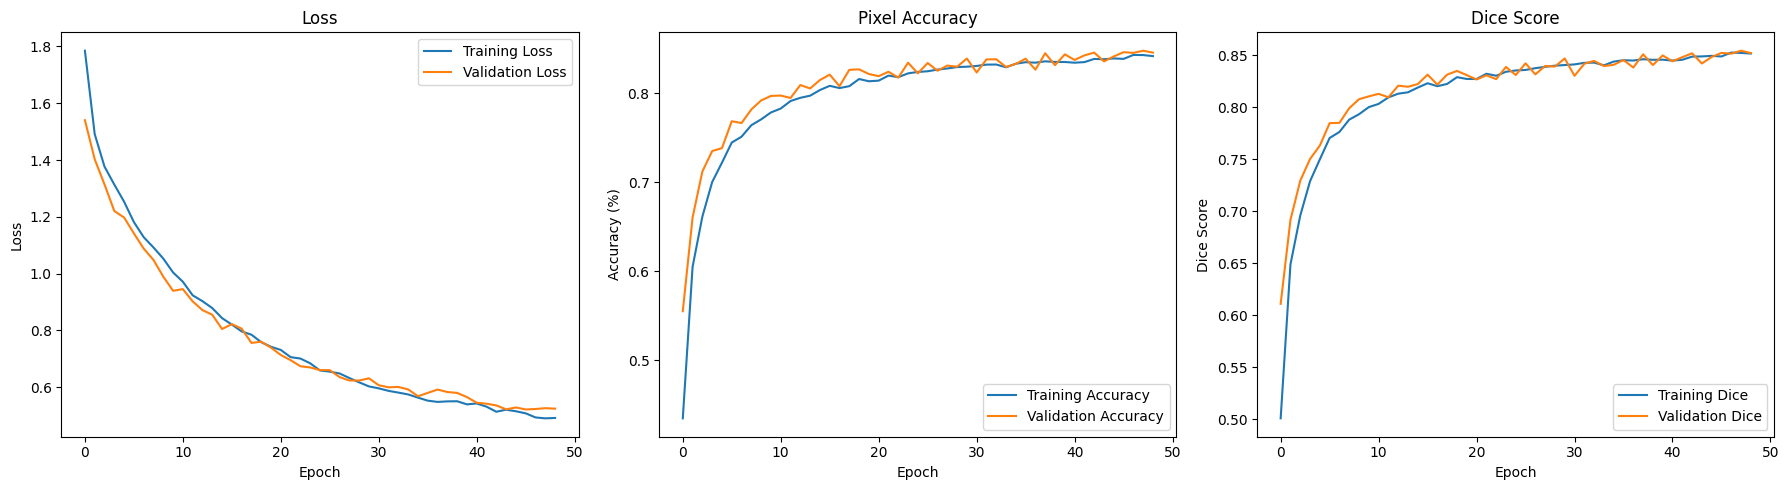

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


 Evaluation Results:
Loss: 0.4570 | Pixel Accuracy: 83.87% | Dice Score: 0.8466 | Mean IoUScore: 0.0519


In [98]:
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)

#### 2nd Experiment: Fine Tuning Model

In [ ]:
# Train only the decoder of Unet
unet = model.UNet(num_classes=8)
unet = unet.to(device)

for layer in [
    unet.encoder0,
    unet.encoder1,
    unet.encoder2,
    unet.encoder3,
    unet.encoder4,
]:
    for param in layer.parameters():
        param.requires_grad = True

enc_lr = 1e-4  # lower learning rate for pretrained encoder
dec_lr = 5e-3  # higher for decoder

optimizer = optim.Adam(
    [
        {"params": unet.encoder0.parameters(), "lr": enc_lr},
        {"params": unet.encoder1.parameters(), "lr": enc_lr},
        {"params": unet.encoder2.parameters(), "lr": enc_lr},
        {"params": unet.encoder3.parameters(), "lr": enc_lr},
        {"params": unet.encoder4.parameters(), "lr": enc_lr},
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)


criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/exp_02_1.pt",
    )
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)


INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 13 channel(s)
Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Epoch 1/50 | Train Loss: 0.8477 | Train Acc: 0.7603 | Train Dice: 0.7809 || Val Loss: 0.6429 | Val Acc: 0.7580 | Val Dice: 0.7788
New best loss: 0.6429


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.96it/s]


Epoch 2/50 | Train Loss: 0.6369 | Train Acc: 0.7872 | Train Dice: 0.8071 || Val Loss: 0.5705 | Val Acc: 0.8125 | Val Dice: 0.8167
New best loss: 0.5705


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.85it/s]


Epoch 3/50 | Train Loss: 0.5419 | Train Acc: 0.8119 | Train Dice: 0.8279 || Val Loss: 0.5448 | Val Acc: 0.7887 | Val Dice: 0.8050
New best loss: 0.5448


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


Epoch 4/50 | Train Loss: 0.5210 | Train Acc: 0.8084 | Train Dice: 0.8242 || Val Loss: 0.4921 | Val Acc: 0.8462 | Val Dice: 0.8527
New best loss: 0.4921


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.90it/s]


Epoch 5/50 | Train Loss: 0.4946 | Train Acc: 0.8217 | Train Dice: 0.8363 || Val Loss: 0.4926 | Val Acc: 0.8411 | Val Dice: 0.8506
 No improvement (1/5)


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


Epoch 6/50 | Train Loss: 0.4685 | Train Acc: 0.8271 | Train Dice: 0.8407 || Val Loss: 0.4869 | Val Acc: 0.8561 | Val Dice: 0.8585
New best loss: 0.4869


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


Epoch 7/50 | Train Loss: 0.4673 | Train Acc: 0.8279 | Train Dice: 0.8426 || Val Loss: 0.4877 | Val Acc: 0.8024 | Val Dice: 0.8223
 No improvement (1/5)


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.90it/s]


Epoch 8/50 | Train Loss: 0.4556 | Train Acc: 0.8278 | Train Dice: 0.8418 || Val Loss: 0.4696 | Val Acc: 0.8203 | Val Dice: 0.8350
New best loss: 0.4696


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


Epoch 9/50 | Train Loss: 0.4267 | Train Acc: 0.8366 | Train Dice: 0.8499 || Val Loss: 0.4135 | Val Acc: 0.8234 | Val Dice: 0.8382
New best loss: 0.4135


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


Epoch 10/50 | Train Loss: 0.4159 | Train Acc: 0.8396 | Train Dice: 0.8526 || Val Loss: 0.4102 | Val Acc: 0.8378 | Val Dice: 0.8474
New best loss: 0.4102


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.88it/s]


Epoch 11/50 | Train Loss: 0.4137 | Train Acc: 0.8414 | Train Dice: 0.8538 || Val Loss: 0.4463 | Val Acc: 0.8267 | Val Dice: 0.8411
 No improvement (1/5)


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


Epoch 12/50 | Train Loss: 0.4028 | Train Acc: 0.8427 | Train Dice: 0.8553 || Val Loss: 0.4519 | Val Acc: 0.8478 | Val Dice: 0.8502
 No improvement (2/5)


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


Epoch 13/50 | Train Loss: 0.4107 | Train Acc: 0.8402 | Train Dice: 0.8535 || Val Loss: 0.4819 | Val Acc: 0.8559 | Val Dice: 0.8637
 No improvement (3/5)


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.88it/s]


Epoch 14/50 | Train Loss: 0.3976 | Train Acc: 0.8447 | Train Dice: 0.8568 || Val Loss: 0.4571 | Val Acc: 0.8482 | Val Dice: 0.8581
 No improvement (4/5)


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


Epoch 15/50 | Train Loss: 0.3765 | Train Acc: 0.8499 | Train Dice: 0.8611 || Val Loss: 0.4031 | Val Acc: 0.8465 | Val Dice: 0.8560
New best loss: 0.4031


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


Epoch 16/50 | Train Loss: 0.3720 | Train Acc: 0.8523 | Train Dice: 0.8631 || Val Loss: 0.4659 | Val Acc: 0.8613 | Val Dice: 0.8669
 No improvement (1/5)


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


Epoch 17/50 | Train Loss: 0.3700 | Train Acc: 0.8532 | Train Dice: 0.8644 || Val Loss: 0.4354 | Val Acc: 0.8527 | Val Dice: 0.8633
 No improvement (2/5)


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


Epoch 18/50 | Train Loss: 0.3672 | Train Acc: 0.8522 | Train Dice: 0.8631 || Val Loss: 0.4051 | Val Acc: 0.8245 | Val Dice: 0.8414
 No improvement (3/5)


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


Epoch 19/50 | Train Loss: 0.3654 | Train Acc: 0.8546 | Train Dice: 0.8653 || Val Loss: 0.4168 | Val Acc: 0.8573 | Val Dice: 0.8668
 No improvement (4/5)


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.80it/s]


Epoch 20/50 | Train Loss: 0.3565 | Train Acc: 0.8566 | Train Dice: 0.8667 || Val Loss: 0.4149 | Val Acc: 0.8110 | Val Dice: 0.8246
 No improvement (5/5)
Early stopping triggered.


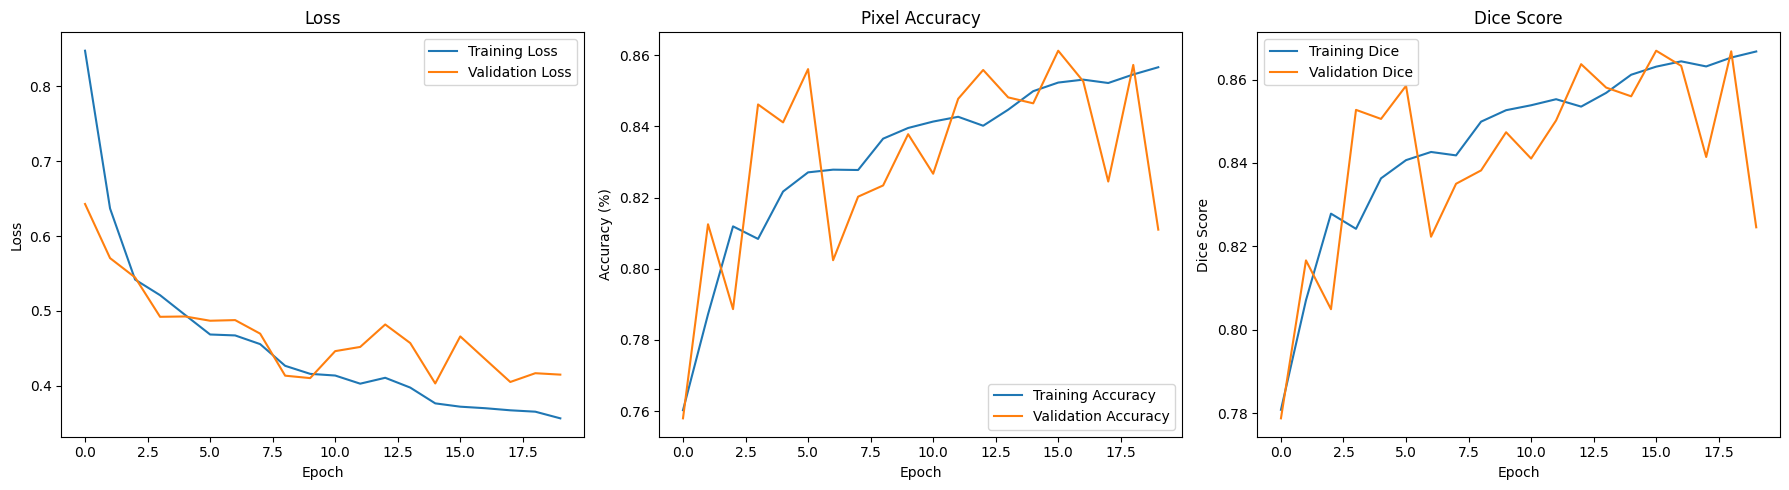

Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


 Evaluation Results:
Loss: 0.4535 | Pixel Accuracy: 81.87% | Dice Score: 0.8323 | Mean IoUScore: 0.2750


In [54]:
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)

In [ ]:
# Train only the decoder of Unet
unet = model.UNet(num_classes=8)
unet = unet.to(device)

ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

for param in unet.encoder0.parameters():
    param.requires_grad = False
for param in unet.encoder1.parameters():
    param.requires_grad = False

# Unfreezing only the 3 last layers of resnet
for layer in [
    unet.encoder2,
    unet.encoder3,
    unet.encoder4,
]:
    for param in layer.parameters():
        param.requires_grad = True

# keep all Batch Normalization layers freezed
# for layer in [unet.encoder2, unet.encoder3, unet.encoder4]:
#     for module in layer.modules():
#         if isinstance(module, nn.BatchNorm2d):
#             for param in module.parameters():
#                 param.requires_grad = False

enc_lr = 1e-4  # lower learning rate for pretrained encoder
dec_lr = 1e-3  # higher for decoder

optimizer = optim.Adam(
    [
        {"params": unet.encoder2.parameters(), "lr": enc_lr},
        {"params": unet.encoder3.parameters(), "lr": enc_lr},
        {"params": unet.encoder4.parameters(), "lr": enc_lr},
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)


criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/exp_02_2.pt",
    )
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 13 channel(s)
Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


Epoch 1/50 | Train Loss: 1.5458 | Train Acc: 0.5079 | Train Dice: 0.5821 || Val Loss: 1.2037 | Val Acc: 0.7254 | Val Dice: 0.7644
New best loss: 1.2037


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Epoch 2/50 | Train Loss: 1.0860 | Train Acc: 0.7473 | Train Dice: 0.7808 || Val Loss: 0.9417 | Val Acc: 0.7576 | Val Dice: 0.7883
New best loss: 0.9417


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


Epoch 3/50 | Train Loss: 0.8632 | Train Acc: 0.7851 | Train Dice: 0.8066 || Val Loss: 0.7471 | Val Acc: 0.7932 | Val Dice: 0.8102
New best loss: 0.7471


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


Epoch 4/50 | Train Loss: 0.7344 | Train Acc: 0.7968 | Train Dice: 0.8163 || Val Loss: 0.6561 | Val Acc: 0.8089 | Val Dice: 0.8253
New best loss: 0.6561


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Epoch 5/50 | Train Loss: 0.6678 | Train Acc: 0.8086 | Train Dice: 0.8252 || Val Loss: 0.6158 | Val Acc: 0.8251 | Val Dice: 0.8360
New best loss: 0.6158


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


Epoch 6/50 | Train Loss: 0.6135 | Train Acc: 0.8147 | Train Dice: 0.8301 || Val Loss: 0.5724 | Val Acc: 0.8274 | Val Dice: 0.8321
New best loss: 0.5724


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Epoch 7/50 | Train Loss: 0.5795 | Train Acc: 0.8186 | Train Dice: 0.8331 || Val Loss: 0.5956 | Val Acc: 0.8199 | Val Dice: 0.8356
 No improvement (1/5)


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch 8/50 | Train Loss: 0.5541 | Train Acc: 0.8230 | Train Dice: 0.8368 || Val Loss: 0.5392 | Val Acc: 0.8340 | Val Dice: 0.8450
New best loss: 0.5392


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch 9/50 | Train Loss: 0.5396 | Train Acc: 0.8267 | Train Dice: 0.8401 || Val Loss: 0.5133 | Val Acc: 0.8257 | Val Dice: 0.8368
New best loss: 0.5133


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch 10/50 | Train Loss: 0.5249 | Train Acc: 0.8246 | Train Dice: 0.8385 || Val Loss: 0.5098 | Val Acc: 0.8096 | Val Dice: 0.8272
New best loss: 0.5098


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


Epoch 11/50 | Train Loss: 0.5117 | Train Acc: 0.8281 | Train Dice: 0.8412 || Val Loss: 0.5312 | Val Acc: 0.8426 | Val Dice: 0.8519
 No improvement (1/5)


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


Epoch 12/50 | Train Loss: 0.5019 | Train Acc: 0.8302 | Train Dice: 0.8428 || Val Loss: 0.4811 | Val Acc: 0.8269 | Val Dice: 0.8378
New best loss: 0.4811


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch 13/50 | Train Loss: 0.4791 | Train Acc: 0.8349 | Train Dice: 0.8473 || Val Loss: 0.4790 | Val Acc: 0.8456 | Val Dice: 0.8522
New best loss: 0.4790


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch 14/50 | Train Loss: 0.4661 | Train Acc: 0.8390 | Train Dice: 0.8507 || Val Loss: 0.4747 | Val Acc: 0.8252 | Val Dice: 0.8400
New best loss: 0.4747


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


Epoch 15/50 | Train Loss: 0.4668 | Train Acc: 0.8377 | Train Dice: 0.8500 || Val Loss: 0.4946 | Val Acc: 0.8480 | Val Dice: 0.8557
 No improvement (1/5)


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


Epoch 16/50 | Train Loss: 0.4636 | Train Acc: 0.8390 | Train Dice: 0.8507 || Val Loss: 0.4582 | Val Acc: 0.8405 | Val Dice: 0.8476
New best loss: 0.4582


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


Epoch 17/50 | Train Loss: 0.4488 | Train Acc: 0.8408 | Train Dice: 0.8523 || Val Loss: 0.4515 | Val Acc: 0.8575 | Val Dice: 0.8622
New best loss: 0.4515


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch 18/50 | Train Loss: 0.4440 | Train Acc: 0.8446 | Train Dice: 0.8557 || Val Loss: 0.4404 | Val Acc: 0.8415 | Val Dice: 0.8523
New best loss: 0.4404


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch 19/50 | Train Loss: 0.4503 | Train Acc: 0.8414 | Train Dice: 0.8529 || Val Loss: 0.4544 | Val Acc: 0.8419 | Val Dice: 0.8487
 No improvement (1/5)


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch 20/50 | Train Loss: 0.4441 | Train Acc: 0.8414 | Train Dice: 0.8528 || Val Loss: 0.4574 | Val Acc: 0.8348 | Val Dice: 0.8457
 No improvement (2/5)


Epoch 21/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch 21/50 | Train Loss: 0.4306 | Train Acc: 0.8457 | Train Dice: 0.8568 || Val Loss: 0.4576 | Val Acc: 0.8587 | Val Dice: 0.8626
 No improvement (3/5)


Epoch 22/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


Epoch 22/50 | Train Loss: 0.4291 | Train Acc: 0.8461 | Train Dice: 0.8568 || Val Loss: 0.4477 | Val Acc: 0.8439 | Val Dice: 0.8539
 No improvement (4/5)


Epoch 23/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]

Epoch 23/50 | Train Loss: 0.4236 | Train Acc: 0.8457 | Train Dice: 0.8569 || Val Loss: 0.4535 | Val Acc: 0.8399 | Val Dice: 0.8501
 No improvement (5/5)
Early stopping triggered.


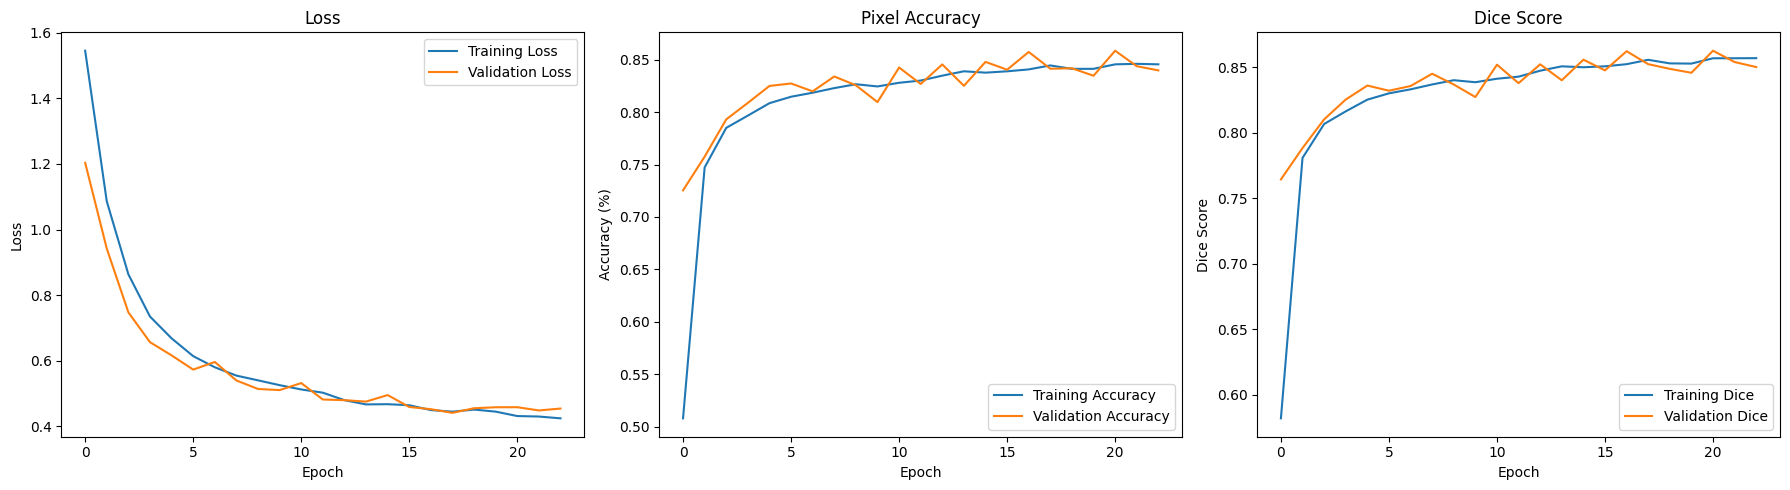

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


 Evaluation Results:
Loss: 0.4559 | Pixel Accuracy: 83.22% | Dice Score: 0.8433 | Mean IoUScore: 0.0711


In [102]:
t.plot_history(
    train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)

### 3d Experiment: Fibonacci Method

In [ ]:
# Train UNet
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for param in unet.encoder0.parameters():
    param.requires_grad = False
for param in unet.encoder1.parameters():
    param.requires_grad = False
for param in unet.encoder2.parameters():
    param.requires_grad = False
for param in unet.encoder3.parameters():
    param.requires_grad = False
for param in unet.encoder4.parameters():
    param.requires_grad = False

# Train only the decoder of Unet

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        num_classes=8,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        save_name="output/fbn_1.pt",
    )
)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test, criterion)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 13 channel(s)
Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Epoch 1/50 | Train Loss: 0.9304 | Train Acc: 0.7501 | Train Dice: 0.7724 || Val Loss: 0.6850 | Val Acc: 0.7542 | Val Dice: 0.7813
New best loss: 0.6850


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


Epoch 2/50 | Train Loss: 0.6303 | Train Acc: 0.7956 | Train Dice: 0.8133 || Val Loss: 0.5638 | Val Acc: 0.8068 | Val Dice: 0.8247
New best loss: 0.5638


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


Epoch 3/50 | Train Loss: 0.5817 | Train Acc: 0.8074 | Train Dice: 0.8235 || Val Loss: 0.5040 | Val Acc: 0.8075 | Val Dice: 0.8211
New best loss: 0.5040


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.79it/s]


Epoch 4/50 | Train Loss: 0.5372 | Train Acc: 0.8162 | Train Dice: 0.8302 || Val Loss: 0.5134 | Val Acc: 0.8039 | Val Dice: 0.8124
 No improvement (1/5)


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Epoch 5/50 | Train Loss: 0.5276 | Train Acc: 0.8180 | Train Dice: 0.8328 || Val Loss: 0.5079 | Val Acc: 0.7899 | Val Dice: 0.8117
 No improvement (2/5)


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.62it/s]


Epoch 6/50 | Train Loss: 0.5001 | Train Acc: 0.8217 | Train Dice: 0.8359 || Val Loss: 0.4751 | Val Acc: 0.8344 | Val Dice: 0.8445
New best loss: 0.4751


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Epoch 7/50 | Train Loss: 0.4890 | Train Acc: 0.8251 | Train Dice: 0.8385 || Val Loss: 0.4796 | Val Acc: 0.8119 | Val Dice: 0.8270
 No improvement (1/5)


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


Epoch 8/50 | Train Loss: 0.4734 | Train Acc: 0.8260 | Train Dice: 0.8395 || Val Loss: 0.4438 | Val Acc: 0.7956 | Val Dice: 0.8147
New best loss: 0.4438


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.75it/s]


Epoch 9/50 | Train Loss: 0.4685 | Train Acc: 0.8250 | Train Dice: 0.8386 || Val Loss: 0.4631 | Val Acc: 0.8381 | Val Dice: 0.8472
 No improvement (1/5)


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


Epoch 10/50 | Train Loss: 0.4565 | Train Acc: 0.8300 | Train Dice: 0.8432 || Val Loss: 0.4495 | Val Acc: 0.8366 | Val Dice: 0.8449
 No improvement (2/5)


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Epoch 11/50 | Train Loss: 0.4431 | Train Acc: 0.8321 | Train Dice: 0.8449 || Val Loss: 0.4740 | Val Acc: 0.8345 | Val Dice: 0.8414
 No improvement (3/5)


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Epoch 12/50 | Train Loss: 0.4316 | Train Acc: 0.8364 | Train Dice: 0.8487 || Val Loss: 0.4287 | Val Acc: 0.8354 | Val Dice: 0.8454
New best loss: 0.4287


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Epoch 13/50 | Train Loss: 0.4200 | Train Acc: 0.8388 | Train Dice: 0.8508 || Val Loss: 0.4258 | Val Acc: 0.8308 | Val Dice: 0.8413
New best loss: 0.4258


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


Epoch 14/50 | Train Loss: 0.4176 | Train Acc: 0.8385 | Train Dice: 0.8503 || Val Loss: 0.4206 | Val Acc: 0.8468 | Val Dice: 0.8559
New best loss: 0.4206


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Epoch 15/50 | Train Loss: 0.4148 | Train Acc: 0.8403 | Train Dice: 0.8521 || Val Loss: 0.4731 | Val Acc: 0.8354 | Val Dice: 0.8471
 No improvement (1/5)


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Epoch 16/50 | Train Loss: 0.4112 | Train Acc: 0.8389 | Train Dice: 0.8514 || Val Loss: 0.4292 | Val Acc: 0.8295 | Val Dice: 0.8418
 No improvement (2/5)


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Epoch 17/50 | Train Loss: 0.4077 | Train Acc: 0.8421 | Train Dice: 0.8537 || Val Loss: 0.4243 | Val Acc: 0.8320 | Val Dice: 0.8441
 No improvement (3/5)


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.54it/s]


Epoch 18/50 | Train Loss: 0.3974 | Train Acc: 0.8451 | Train Dice: 0.8561 || Val Loss: 0.4242 | Val Acc: 0.8359 | Val Dice: 0.8467
 No improvement (4/5)


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Epoch 19/50 | Train Loss: 0.4029 | Train Acc: 0.8419 | Train Dice: 0.8537 || Val Loss: 0.4296 | Val Acc: 0.8633 | Val Dice: 0.8676
 No improvement (5/5)
Early stopping triggered.


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


 Evaluation Results:
Loss: 0.4359 | Pixel Accuracy: 86.83% | Dice Score: 0.8715
